### Bayesian Data Analysis, 3rd ed
## Chapter 3, demos 1-4

Examples and illustrations for a normal model with unknown mean and variance
(BDA3 section 3.2 on p. 64).

We have a vector of observations in one dimension $y$.

In [1]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt

# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import sinvchi2
import plot_tools

In [2]:
plt.rc('font', size=12)
plt.style.use(plot_tools.custom_styles['gray_background'])

In [3]:
# data
y = np.array([93, 112, 122, 135, 122, 150, 118, 90, 124, 114])

# sufficient statistics
n = len(y)
s2 = np.var(y, ddof=1)  # here ddof=1 is used to get the sample estimate
my = np.mean(y)

In [4]:
# set random number generator with seed
rng = np.random.RandomState(seed=0)

We can factorize the joint posterior distribution as:

$$p(\mu, \sigma^2 \mid y) = p(\mu \mid \sigma^2, y) \, p(\sigma^2 \mid y) $$

Given we know the analytic form of the posterior we can directly sample from it.

Specifically we have the posterior of $\sigma^2$ as:

$$\sigma^2 \mid y \sim \text{Inv-} \chi^2(n-1, s^2)$$ 

where $s^2$ is the variance of $y$.

And the posterior of $\mu$ as:

$$\mu \mid \sigma^2, y \sim \mathcal{N}(\bar{y}, \sigma^2/n)$$

If we integrate the joint posterior wrt $\sigma^2$ to get the marginal posterior of $\mu$ we can view this as a mixture of normal distributions:

\begin{equation} \label{eq1}
\begin{split}
p(\mu \mid y) & = \int \, d \sigma^2 \, p(\mu, \sigma^2 \mid y)  \\
 & = \int \, d \sigma^2 \, p(\mu \mid \sigma^2, y) \, p(\sigma^2 \mid y) \\
 & = \int \, d \sigma^2 \, \mathcal{N}(\bar{y}, \sigma^2 /n) \, \text{Inv-} \chi^2(n-1, s^2)
\end{split}
\end{equation}

which we plot below in section 3.

We can also sample from the posterior predictive by using these samples from the posterior and plugging into the likelihood, which is, just to recall:

$$y \sim \mathcal{N}(\mu, \sigma^2)$$

In [5]:
sigma2 = sinvchi2.rvs(n-1, s2, size=1000, random_state=rng)
mu = my + np.sqrt(sigma2/n)*rng.randn(*sigma2.shape)
sigma = np.sqrt(sigma2)
ynew = rng.randn(*mu.shape)*sigma + mu

#### Set-up plotting

In [6]:
# for mu compute the density in these points
tl1 = [90, 150]
mu_grid = np.linspace(tl1[0], tl1[1], 1000)
# for sigma compute the density in these points
tl2 = [10, 60]
sig_grid = np.linspace(tl2[0], tl2[1], 1000)
# for ynew compute the density in these points
tlynew = [50, 185]
xynew = np.linspace(tlynew[0], tlynew[1], 1000)

Now we'll evaluate the joint evaluate the joint density in a grid note that the following is not normalized, but for plotting contours it does not matter.

`Z` is thus a $(1000, 1000)$ array with the exact posterior density at each point of $(\mu, \sigma^2)$ in a grid.

We basically evaluate $p(\mu, \sigma^2 \mid y) = p(\mu \mid \sigma^2, y) \, p(\sigma^2 \mid y) $ for a grid of $\mu$ and $\sigma^2$ values.

In [7]:
Z = stats.norm.pdf(x=mu_grid, loc=my, scale=sig_grid[:,np.newaxis]/np.sqrt(n)) # posterior of mu at different values
Z *= (sinvchi2.pdf(x=sig_grid**2, nu=n-1, s2=s2)*2*sig_grid)[:,np.newaxis]  # multiply by posterior of sigma^2 to get joint unnormalized posterior

We can now calculate, for both $\mu$ and $\sigma^2$ the exact marginal density and plot this against a KDE estimate from the posterior samples.

As per BDA3 the marginal for $\mu$ is:

$$\frac{\mu - \bar{y}}{s/\sqrt{n}} \, \Big| \, y \sim t_{n-1}$$

and so we evaluate the density of a $t$-distribution with $n-1$ degrees of freedom.

We get the exact marginals over the defined grid. Note per the transformation of variables we need to scale the pdf of the standardized variable

In [9]:
pm_mu = stats.t.pdf((mu_grid - my) / np.sqrt(s2/n), n-1) / np.sqrt(s2/n)
pm_sigma = sinvchi2.pdf(sig_grid**2, n-1, s2)*2*sig_grid

# estimate marginal density for mu & sigma using samples & ad-hoc Gaussian KDE
pk_mu = stats.gaussian_kde(mu).evaluate(mu_grid)
pk_sigma = stats.gaussian_kde(sigma).evaluate(sig_grid)

# compute the exact predictive density:
p_new = stats.t.pdf((xynew-my)/np.sqrt(s2*(1+1/n)), n-1) / np.sqrt(s2*(1+1/n))

### 1. Visualise the joint density and marginal densities

(of the posterior of normal distribution with unknown mean and variance.)

Joint and marginal posterior distributions


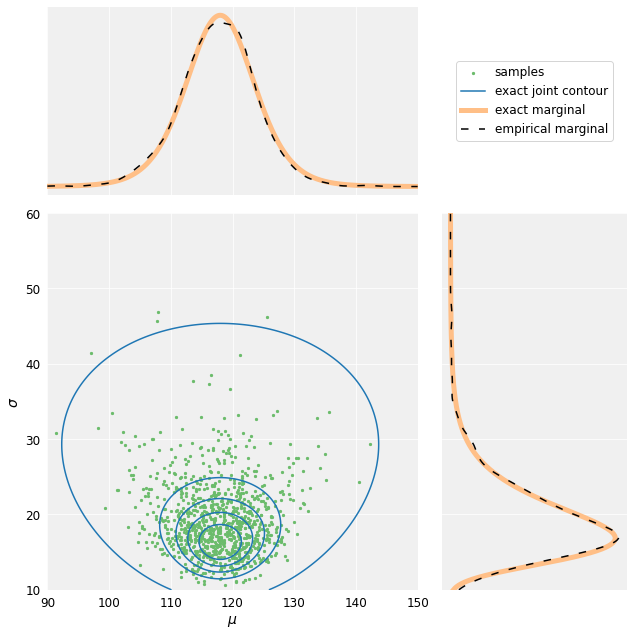

In [10]:
print('Joint and marginal posterior distributions')

# create figure
fig, axes = plt.subplots(
    2, 2,
    figsize=(9, 9),
    gridspec_kw=dict(
        width_ratios=[2, 1],
        height_ratios=[1, 2]
    )
)

# plot the joint distribution
ax = axes[1, 0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(mu_grid, sig_grid, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize='14')
ax.set_ylabel('$\sigma$', fontsize='14')

# plot the marginal of mu
ax = axes[0, 0]
# exact
ax.plot(
    mu_grid,
    pm_mu,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
ax.plot(
    mu_grid,
    pk_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_xlim(tl1)
ax.set_yticks(())
ax.set_xticklabels(())

# plot the marginal of sigma
ax = axes[1, 1]
# exact
exact_line, = ax.plot(
    pm_sigma,
    sig_grid,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
empirical_line, = ax.plot(
    pk_sigma,
    sig_grid,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_ylim(tl2)
ax.set_xticks(())
ax.set_yticklabels(())

# hide last ax
ax = axes[0, 1]
ax.axis('off')
# make legend there
ax.legend(
    (
        samps,
        plt.Line2D([], [], color='C0'),
        exact_line,
        empirical_line
    ),
    (
        'samples',
        'exact joint contour',
        'exact marginal',
        'empirical marginal'
    ),
    loc='center',
)

fig.tight_layout()

### 2. Visualise factored sampling and the corresponding marginal and conditional densities.

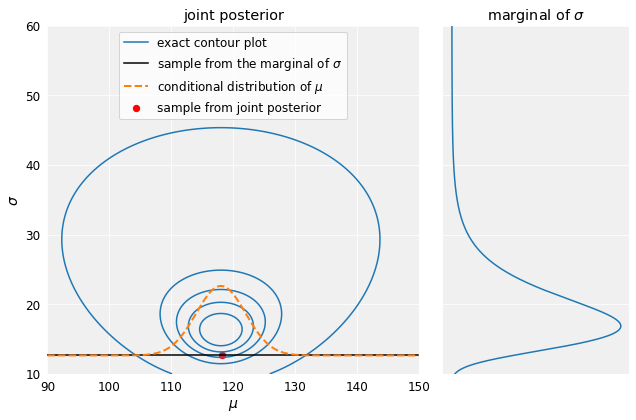

In [17]:
# create figure
fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 6),
    gridspec_kw=dict(width_ratios=[2, 1])
)

# plot the joint distribution
ax = axes[0]
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(mu_grid, sig_grid, Z, c_levels, colors='C0')

# plot the first sample
line1, = ax.plot(tl1, [sigma[0], sigma[0]], 'k')
line2, = ax.plot(
    mu_grid,
    sigma[0] + stats.norm.pdf(mu_grid, my, np.sqrt(sigma2[0]/n))*100,
    color='C1',
    linestyle='dashed',
    linewidth=2
)
scat = ax.scatter(mu[0], sigma[0], 40, color='r')

# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_title('joint posterior')
ax.legend(
    (plt.Line2D([], [], color='C0'), line1, line2, scat),
    ('exact contour plot',
     'sample from the marginal of $\\sigma$',
     'conditional distribution of $\\mu$',
     'sample from joint posterior'),
    loc='upper center'
)

# plot the marginal of sigma
ax = axes[1]
ax.plot(pm_sigma, sig_grid)
# decorate
ax.set_ylim(tl2)
ax.set_title('marginal of $\sigma$')
ax.set_xticks(());
ax.set_yticklabels(())

fig.tight_layout()

### 3. Visualise the marginal distribution of $\mu$ as a mixture of normals.


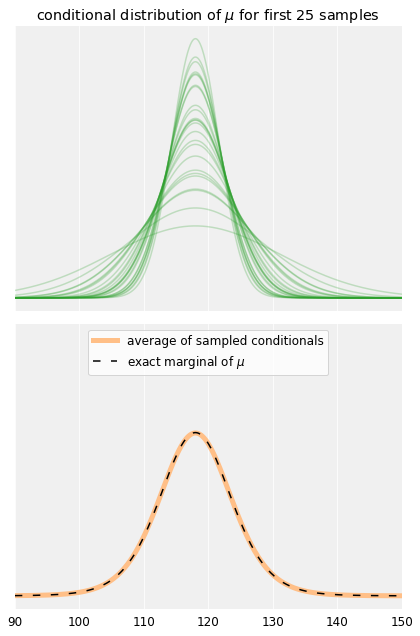

In [34]:
# calculate conditional pdfs for each sample from the posterior of sigma2
condpdfs = stats.norm.pdf(mu_grid, my, np.sqrt(sigma2/n)[:, np.newaxis])

# create figure
fig, axes = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

# plot some of them
ax = axes[0]
ax.plot(mu_grid, condpdfs[:25].T, 'C2', alpha=0.25)
ax.set_xlim(tl1)
ylims_from_0 = ax.set_ylim()  # set same y_lims to the next plot
ax.set_title('conditional distribution of $\\mu$ for first 25 samples')
ax.set_yticks(())

# plot their mean
ax = axes[1]
ax.plot(
    mu_grid,
    np.mean(condpdfs, axis=0),
    color=plot_tools.lighten('C1'),
    linewidth=5,
    label='average of sampled conditionals'
)
ax.plot(
    mu_grid,
    pm_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5,
    label='exact marginal of $\\mu$'
)
ax.set_yticks(())
ax.set_xlim(tl1)
ax.set_ylim(ylims_from_0)
ax.legend(loc='upper center')

fig.tight_layout()

### 4. Visualise sampling from the posterior predictive distribution.

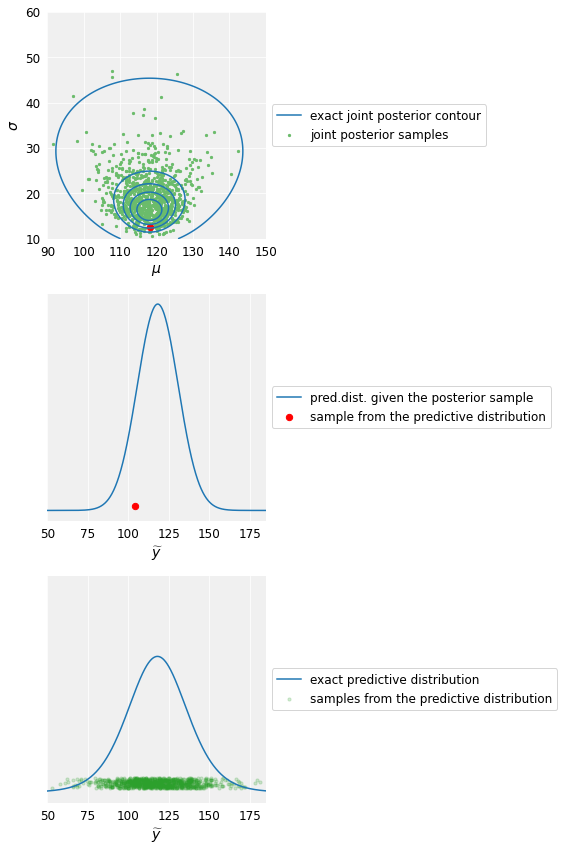

In [35]:
# calculate predictive pdf for the first given mu and sigma sample
ynewdists = stats.norm.pdf(xynew, mu[0], sigma[0])

# create figure
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# plot the joint distribution
ax = axes[0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(mu_grid, sig_grid, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.legend(
    (plt.Line2D([], [], color='C0'), samps),
    ('exact joint posterior contour', 'joint posterior samples'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
# highlight the first sample
ax.scatter(mu[0], sigma[0], 40, 'r')

# plot first ynew
ax = axes[1]
# plot the distribution and the respective sample
line1, = ax.plot(xynew, ynewdists)
ax1_hs = ax.scatter(ynew[0], 0.02*np.max(ynewdists), 40, 'r')
# decorate
ylims_from_1 = ax.set_ylim()
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(
    (line1, ax1_hs),
    ('pred.dist. given the posterior sample',
    'sample from the predictive distribution'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

# plot all ynews
ax = axes[2]
ax.scatter(
    ynew,
    (0.02 + 0.05*rng.rand(*ynew.shape))*np.max(ynewdists),
    10,
    color='C2',
    alpha=0.2,
    label='samples from the predictive distribution'
)
ax.plot(
    xynew,
    p_new,
    linewidth=1.5,
    label='exact predictive distribution'
)
ax.set_ylim(ylims_from_1)
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()